<h1  style="color: rgba(80, 172, 20, 1);">Detecção de Ataque DDoS com Aprendizado de Máquina Não Supervisionado Utilizando Isolation Forest</h1>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

<p>Dentro do CIC-DDoS2019 foram escolhidos 3 datasets para serem importados e treinar o iForest, os 3 principais e mais recorrentes ataques DDoS: UDP, DNS e SYN</p>
<p>Todos os datasets estão disponíveis no link: <a>https://www.unb.ca/cic/datasets/ddos-2019.html</a></p>

In [2]:
df_udp = pd.read_csv(r'C:\data_science_iforest_ddos\dataset\training\CSV-01-12\01-12\DrDoS_UDP.csv', index_col=0)
df_dns = pd.read_csv(r'C:\data_science_iforest_ddos\dataset\training\CSV-01-12\01-12\DrDoS_DNS.csv', index_col=0)
df_ntp = pd.read_csv(r'C:\data_science_iforest_ddos\dataset\training\CSV-01-12\01-12\DrDoS_NTP.csv', index_col=0)

C:\Users\talle\AppData\Local\Temp\ipykernel_12268\254610171.py:1: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  df_udp = pd.read_csv(r'C:\data_science_iforest_ddos\dataset\training\CSV-01-12\01-12\DrDoS_UDP.csv', index_col=0)
C:\Users\talle\AppData\Local\Temp\ipykernel_12268\254610171.py:2: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  df_dns = pd.read_csv(r'C:\data_science_iforest_ddos\dataset\training\CSV-01-12\01-12\DrDoS_DNS.csv', index_col=0)
C:\Users\talle\AppData\Local\Temp\ipykernel_12268\254610171.py:3: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ntp = pd.read_csv(r'C:\data_science_iforest_ddos\dataset\training\CSV-01-12\01-12\DrDoS_NTP.csv', index_col=0)


<p>É importado um dataset do CIC-DDoS2019 não utilizado no processo de treinamento, apenas para a validação externa</p>

In [3]:
df_test_udp = pd.read_csv(r'C:\data_science_iforest_ddos\dataset\tests\CSV-03-11\03-11\UDP.csv', index_col=0)

C:\Users\talle\AppData\Local\Temp\ipykernel_12268\2880599188.py:1: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  df_test_udp = pd.read_csv(r'C:\data_science_iforest_ddos\dataset\tests\CSV-03-11\03-11\UDP.csv', index_col=0)


In [4]:
df_test_syn = pd.read_csv(r'C:\data_science_iforest_ddos\dataset\tests\CSV-03-11\03-11\Syn.csv', index_col=0)

C:\Users\talle\AppData\Local\Temp\ipykernel_12268\2693003262.py:1: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  df_test_syn = pd.read_csv(r'C:\data_science_iforest_ddos\dataset\tests\CSV-03-11\03-11\Syn.csv', index_col=0)


In [5]:
# df_test_udplag = pd.read_csv(r'C:\data_science_iforest_ddos\dataset\tests\CSV-03-11\03-11\UDPLag.csv', index_col=0)

In [6]:
# df_test_ldap = pd.read_csv(r'C:\data_science_iforest_ddos\dataset\tests\CSV-03-11\03-11\LDAP.csv', index_col=0)

In [7]:
df_test_syn.shape

(4320541, 87)

In [8]:
df_list = [df_udp, df_dns, df_ntp]

In [9]:
print('UDP:', df_udp.shape, '\nDNS: ', df_dns.shape, '\nNTP:', df_ntp.shape)

UDP: (3136802, 87) 
DNS:  (5074413, 87) 
NTP: (1217007, 87)


In [10]:
df_dns[' Label']

Unnamed: 0
425      DrDoS_DNS
430      DrDoS_DNS
1654     DrDoS_DNS
2927     DrDoS_DNS
694      DrDoS_DNS
           ...    
6364     DrDoS_DNS
5576     DrDoS_DNS
26506    DrDoS_DNS
18736    DrDoS_DNS
2811     DrDoS_DNS
Name:  Label, Length: 5074413, dtype: object

<p>Concatena a lista de datasets de treino a fim de criar um unico dataset com todas as informações dos 3</p>

In [11]:
concat_df = pd.concat(df_list, ignore_index=True)

<h2 style="color: rgb(100, 200, 34);">Análise Exploratória dos dados do dataset</h2>

In [12]:
concat_df.shape

(9428222, 87)

In [13]:
concat_df.columns

Index(['Flow ID', ' Source IP', ' Source Port', ' Destination IP',
       ' Destination Port', ' Protocol', ' Timestamp', ' Flow Duration',
       ' Total Fwd Packets', ' Total Backward Packets',
       'Total Length of Fwd Packets', ' Total Length of Bwd Packets',
       ' Fwd Packet Length Max', ' Fwd Packet Length Min',
       ' Fwd Packet Length Mean', ' Fwd Packet Length Std',
       'Bwd Packet Length Max', ' Bwd Packet Length Min',
       ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s',
       ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max',
       ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std',
       ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean',
       ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags',
       ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags',
       ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s',
       ' Bwd Packets/s', ' Min Packet Length', ' Max Pa

<p>É feita uma limpeza nos nomes das colunas, por apresentarem um espaço extra inicial, facilitando a leitura e criação de código. Ex: ' Label' -> 'Label'</p>

In [ ]:
concat_df.columns = concat_df.columns.str.strip()
df_test_syn.columns = df_test_syn.columns.str.strip()
df_test_udp.columns = df_test_udp.columns.str.strip()

In [15]:
concat_df.columns

Index(['Flow ID', 'Source IP', 'Source Port', 'Destination IP',
       'Destination Port', 'Protocol', 'Timestamp', 'Flow Duration',
       'Total Fwd Packets', 'Total Backward Packets',
       'Total Length of Fwd Packets', 'Total Length of Bwd Packets',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean', 'Fwd Packet Length Std',
       'Bwd Packet Length Max', 'Bwd Packet Length Min',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
  

In [16]:
concat_df.head()

,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,SimillarHTTP,Inbound,Label
0,172.16.0.5-192.168.50.1-43443-6652-17,172.16.0.5,43443,192.168.50.1,6652,17,2018-12-01 12:36:57.628026,218395,6,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,DrDoS_UDP
1,172.16.0.5-192.168.50.1-54741-9712-17,172.16.0.5,54741,192.168.50.1,9712,17,2018-12-01 12:36:57.628076,108219,4,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,DrDoS_UDP
2,172.16.0.5-192.168.50.1-56589-4680-17,172.16.0.5,56589,192.168.50.1,4680,17,2018-12-01 12:36:57.628164,104579,4,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,DrDoS_UDP
3,172.16.0.5-192.168.50.1-40233-2644-17,172.16.0.5,40233,192.168.50.1,2644,17,2018-12-01 12:36:57.628166,110967,4,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,DrDoS_UDP
4,172.16.0.5-192.168.50.1-33989-16901-17,172.16.0.5,33989,192.168.50.1,16901,17,2018-12-01 12:36:57.628217,1,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,DrDoS_UDP


<p>Verificação de valores nulos no dataset</p>

In [17]:
concat_df.isna().sum()

Flow ID             0
Source IP           0
Source Port         0
Destination IP      0
Destination Port    0
                   ..
Idle Max            0
Idle Min            0
SimillarHTTP        0
Inbound             0
Label               0
Length: 87, dtype: int64

In [18]:
df_test_syn.isna().sum()

Flow ID             0
Source IP           0
Source Port         0
Destination IP      0
Destination Port    0
                   ..
Idle Max            0
Idle Min            0
SimillarHTTP        0
Inbound             0
Label               0
Length: 87, dtype: int64

In [19]:
concat_df.dtypes

Flow ID              object
Source IP            object
Source Port           int64
Destination IP       object
Destination Port      int64
                     ...   
Idle Max            float64
Idle Min            float64
SimillarHTTP         object
Inbound               int64
Label                object
Length: 87, dtype: object

<p>Verificação de quantos valores existem por classe (Label)</p>

In [20]:
concat_df['Label'].value_counts()

Label
DrDoS_DNS    5071011
DrDoS_UDP    3134645
DrDoS_NTP    1202642
BENIGN         19924
Name: count, dtype: int64

In [21]:
df_test_syn['Label'].value_counts()

Label
Syn       4284751
BENIGN      35790
Name: count, dtype: int64

<h2 style="color: rgb(100, 200, 34);">Diminuindo o Dataset de Teste</h2>

<p>Aqui separamos os dados benignos e os malignos em 2 datasets</p>

In [ ]:
df_test_benign_udp = df_test_udp[df_test_udp['Label'] == 'BENIGN']
df_test_benign_udp.head()

,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,SimillarHTTP,Inbound,Label
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
41741,192.168.10.50-192.168.50.8-21-60319-6,192.168.50.8,60319,192.168.10.50,21,6,2018-11-03 10:42:57.648027,9015834,6,0,...,0.000000,3009701.0,3009701.0,6.006131e+06,0.000000e+00,6006131.0,6006131.0,0,1,BENIGN
63,192.168.50.253-224.0.0.5-0-0-0,192.168.50.253,0,224.0.0.5,0,0,2018-11-03 10:42:57.699191,113498356,52,0,...,28.810772,106.0,5.0,9.458180e+06,3.307888e+05,9909241.0,9048680.0,0,0,BENIGN
93238,192.168.50.6-23.194.142.213-55650-443-6,192.168.50.6,55650,23.194.142.213,443,6,2018-11-03 10:42:58.393445,56638650,26,24,...,107279.792294,289179.0,20805.0,9.365196e+06,1.338180e+06,10010988.0,6649735.0,0,0,BENIGN
42899,192.168.50.6-4.2.2.4-52485-53-17,192.168.50.6,52485,4.2.2.4,53,17,2018-11-03 10:42:58.393567,21234,2,2,...,0.000000,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0,0,BENIGN
111954,192.168.50.6-72.21.91.29-55656-80-6,192.168.50.6,55656,72.21.91.29,80,6,2018-11-03 10:42:58.402896,56653775,14,12,...,188.881974,28417.0,27941.0,9.414137e+06,1.452976e+06,10019426.0,6448290.0,0,0,BENIGN


In [25]:
df_test_benign_syn = df_test_syn[df_test_syn['Label'] == 'BENIGN']
df_test_benign_syn.head()

,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,SimillarHTTP,Inbound,Label
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
21,172.217.11.10-192.168.50.6-443-56122-6,192.168.50.6,56122,172.217.11.10,443,6,2018-11-03 11:36:30.766872,111695142,12,6,...,10.606602,62322.0,62307.0,55785096.5,3.911420e+06,58550888.0,53019305.0,0,0,BENIGN
24,172.217.9.225-192.168.50.6-443-56142-6,192.168.50.6,56142,172.217.9.225,443,6,2018-11-03 11:36:31.766957,111710871,12,6,...,16.263456,62256.0,62233.0,55792981.5,3.900332e+06,58550933.0,53035030.0,0,0,BENIGN
26,172.217.10.226-192.168.50.6-443-56123-6,192.168.50.6,56123,172.217.10.226,443,6,2018-11-03 11:36:31.767006,111711024,12,6,...,16.970563,62230.0,62206.0,55792985.5,3.900334e+06,58550938.0,53035033.0,0,0,BENIGN
30,172.217.12.194-192.168.50.6-443-56147-6,192.168.50.6,56147,172.217.12.194,443,6,2018-11-03 11:36:32.782636,111695541,12,6,...,14.849242,62295.0,62274.0,55785121.5,3.911318e+06,58550841.0,53019402.0,0,0,BENIGN
32,172.217.6.227-192.168.50.6-443-56149-6,192.168.50.6,56149,172.217.6.227,443,6,2018-11-03 11:36:32.782688,111695685,12,6,...,23.334524,62276.0,62243.0,55785122.0,3.911323e+06,58550845.0,53019399.0,0,0,BENIGN


In [26]:
df_test_benign_syn.shape

(35790, 87)

In [ ]:
df_test_malign_udp = df_test_udp[df_test_udp['Label'] == 'UDP']
df_test_malign_udp.head(3)

,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,SimillarHTTP,Inbound,Label
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
83785,172.16.0.5-192.168.50.4-27799-14566-17,172.16.0.5,27799,192.168.50.4,14566,17,2018-11-03 10:52:00.076641,3,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,UDP
44813,172.16.0.5-192.168.50.4-61850-2225-17,172.16.0.5,61850,192.168.50.4,2225,17,2018-11-03 10:52:00.153256,3,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,UDP
72764,172.16.0.5-192.168.50.4-61850-3815-17,172.16.0.5,61850,192.168.50.4,3815,17,2018-11-03 10:52:00.217932,3,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,UDP


In [35]:
df_test_malign_syn = df_test_syn[df_test_syn['Label'] == 'Syn']
df_test_malign_syn.head(3)

,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,SimillarHTTP,Inbound,Label
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
445444,172.16.0.5-192.168.50.4-9429-9429-6,172.16.0.5,9429,192.168.50.4,9429,6,2018-11-03 11:36:28.607338,36063894,7,2,...,29.444864,52.0,1.0,1.202128e+07,6.253623e+06,18628035.0,6193840.0,0,1,Syn
113842,172.16.0.5-192.168.50.4-60224-60224-6,172.16.0.5,60224,192.168.50.4,60224,6,2018-11-03 11:36:28.607339,44851366,8,4,...,0.000000,1.0,1.0,2.066268e+07,1.169783e+07,28934293.0,12391060.0,0,1,Syn
176377,172.16.0.5-192.168.50.4-33827-11746-6,192.168.50.4,11746,172.16.0.5,33827,6,2018-11-03 11:36:28.607388,1,2,0,...,0.000000,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0,0,Syn


In [36]:
df_test_malign_syn.shape

(4284751, 87)

<p>A quantidade de ataques sera calculado a partir dessa proporção</p>

In [37]:
n_attacks_udp = len(df_test_benign_udp) / 1.5
n_attacks_udp

2089.3333333333335

In [38]:
n_attacks_syn= len(df_test_benign_syn) / 1.5
n_attacks_syn

23860.0

<p>Os dados malignos sofrerão uma diminuição utilizando a função sample</p>

In [39]:
df_test_malign_udp = df_test_malign_udp.sample(n=int(n_attacks_udp), random_state=42)
df_test_malign_udp.shape

(2089, 87)

In [40]:
df_test_malign_syn = df_test_malign_syn.sample(n=int(n_attacks_syn), random_state=42)
df_test_malign_syn.shape

(23860, 87)

<p>Após a diminuição os datasets são concatenados novamente</p>

In [41]:
df_test_concat_udp = pd.concat([df_test_benign_udp, df_test_malign_udp])

In [42]:
df_test_concat_syn = pd.concat([df_test_benign_syn, df_test_malign_syn])

In [43]:
df_test_concat_syn.shape

(59650, 87)

<h2 style="color: rgb(100, 200, 34);">Diminuindo o Dataset de Treino</h2>

<p>O dataset apresenta uma discrepância muito grande no total de valores benignos e os ataques, com uma quantidade muito maior de ataques do que valores normais. Porém, para treinar corretamente o iForest, a proporção deveria ser contrária, com muito mais dados benignos do que ataques, pois o algoritmo irá classificar como anomalia o dado que tiver menor quantidade e para verificação de uma rede normal, onde há muitos mais dados benignos do que malignos. Logo a proporção deverá ser mudado através dos códigos abaixo.</p>

<p>Aqui serão feitos os mesmos processos dos dados de teste, mas com algumas mudanças</p>

In [44]:
df_benign = concat_df[concat_df['Label'] == 'BENIGN']
df_benign.head()

,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,SimillarHTTP,Inbound,Label
29378,192.168.10.50-192.168.50.8-22-59643-6,192.168.50.8,59643,192.168.10.50,22,6,2018-12-01 12:37:02.186488,1,2,0,...,0.000000e+00,0.0,0.0,0.00,0.000000e+00,0.0,0.0,0,1,BENIGN
33433,192.168.50.6-23.194.142.15-57664-443-6,192.168.50.6,57664,23.194.142.15,443,6,2018-12-01 12:37:03.069132,266,5,0,...,0.000000e+00,0.0,0.0,0.00,0.000000e+00,0.0,0.0,0,0,BENIGN
33436,192.168.50.6-23.194.142.15-57664-443-6,192.168.50.6,57664,23.194.142.15,443,6,2018-12-01 12:37:03.069399,20637,1,5,...,0.000000e+00,0.0,0.0,0.00,0.000000e+00,0.0,0.0,0,0,BENIGN
33530,192.168.50.6-23.194.142.15-57664-443-6,23.194.142.15,443,192.168.50.6,57664,6,2018-12-01 12:37:03.090080,148,1,2,...,0.000000e+00,0.0,0.0,0.00,0.000000e+00,0.0,0.0,0,1,BENIGN
34281,192.168.50.254-224.0.0.5-0-0-0,192.168.50.254,0,224.0.0.5,0,0,2018-12-01 12:37:03.267708,113580323,42,0,...,1.199478e+06,4155120.0,3.0,9118762.25,1.172700e+06,9958914.0,5512480.0,0,0,BENIGN


In [45]:
n_attacks = len(df_benign) / 4
n_attacks

4981.0

In [46]:
df_malign_dns = concat_df[concat_df['Label'] == 'DrDoS_DNS']
df_malign_udp = concat_df[concat_df['Label'] == 'DrDoS_UDP']
df_malign_ntp = concat_df[concat_df['Label'] == 'DrDoS_NTP']

MemoryError: Unable to allocate 55.1 MiB for an array with shape (6, 1202642) and data type int64

In [ ]:
df_malign_dns['Label'].value_counts()

Label
DrDoS_DNS    5071011
Name: count, dtype: int64

In [ ]:
df_malign_udp['Label'].value_counts()

Label
DrDoS_UDP    3134645
Name: count, dtype: int64

In [ ]:
df_malign_ntp['Label'].value_counts()


Label
DrDoS_NTP    1202642
Name: count, dtype: int64

In [ ]:
total_attacks = len(df_malign_dns) + len(df_malign_ntp) + len(df_malign_udp)
total_attacks

9408298

In [ ]:
dns_frac = len(df_malign_dns) / total_attacks
udp_frac = len(df_malign_udp) / total_attacks
ntp_frac = len(df_malign_ntp) / total_attacks
print('DNS: ', dns_frac, '\nUDP: ', udp_frac, '\nNTP: ', ntp_frac)

DNS:  0.5389934502499815 
UDP:  0.33317875347910964 
NTP:  0.12782779627090893


In [ ]:
dns_sample = df_malign_dns.sample(n=int(n_attacks * dns_frac), random_state=42)
udp_sample = df_malign_udp.sample(n=int(n_attacks * udp_frac), random_state=42)
ntp_sample = df_malign_ntp.sample(n=int(n_attacks * ntp_frac), random_state=42)
print('DNS: ', len(dns_sample), '\nUDP: ', len(udp_sample), '\nNTP: ', len(ntp_sample))

DNS:  2684 
UDP:  1659 
NTP:  636


In [ ]:
df_attacks = pd.concat([dns_sample, udp_sample, ntp_sample])
df_attacks.shape

(4979, 87)

In [ ]:
small_concat_df = pd.concat([df_benign, df_attacks], ignore_index=True)

<p>Aqui trocamos os valores 'BENIGN' e o nome do ataque para valores binários (0 e 1) a fim de falicitar no processo de aprendizagem do algoritmo</p>

In [ ]:
small_concat_df['Label'] = small_concat_df['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)

<p>Por fim, o dataset agora conta com 25mil dados, sendo 19924 deles e 4979 malignos</p>

In [ ]:
small_concat_df['Label'].value_counts()

Label
0    19924
1     4979
Name: count, dtype: int64

In [ ]:
# small_concat_df[concat_df.duplicated()]

<h2  style="color: rgb(100, 200, 34);">Retirar Colunas/Features não importantes</h2> 

In [ ]:
small_concat_df['SimillarHTTP'].value_counts()

SimillarHTTP
0                                                                                     17286
0                                                                                      6831
ocsp.pki.goog/GTSGIAG3                                                                  111
ocsp.digicert.com/                                                                       96
drmokhberi.ca/favicon.ico                                                                22
                                                                                      ...  
talebi.ca/wp-content/plugins/wpdiscuz/utils/captcha/captcha.php?key=c5c029d5fedbb7        1
0.gravatar.com/avatar/?s=48&d=mm&r=g                                                      1
talebi.ca/wp-content/plugins/wpdiscuz/utils/captcha/captcha.php?key=c5c029ef1bbdf9        1
talebi.ca/wp-content/plugins/wpdiscuz/utils/captcha/captcha.php?key=c5c029ef1bc09a        1
205.174.165.72/c.php?ip=10.148.118.37                              

<p>Retirar colunas de identificação</p>

In [ ]:
columns_drop = ['Flow ID', 'Source IP', 'Source Port', 'Destination IP', 'Destination Port', 'Timestamp', 'SimillarHTTP']
small_concat_df = small_concat_df.drop(columns=columns_drop)

In [ ]:
df_test_concat_udp = df_test_concat_udp.drop(columns=columns_drop)

In [ ]:
df_test_concat_syn = df_test_concat_syn.drop(columns=columns_drop)

In [ ]:
small_concat_df.shape

(24903, 80)

In [ ]:
df_test_concat_syn.shape

(44737, 80)

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
small_concat_df.head()

,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Inbound,Label
0,6,1,2,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,2.000000e+06,1.000000e+00,0.000000e+00,1.0,1.0,1.0,1.000000e+00,0.000000e+00,1.0,1.0,0.0,0.00,0.0,0.0,0.0,0,0,0,0,56,0,2.000000e+06,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0,0,0,0,1,0,0,0,0.0,0.000000,0.0,0.0,56,0,0,0,0,0,0,2,0,0,0,8192,-1,0,28,0.00,0.000000e+00,0.0,0.0,0.00,0.000000e+00,0.0,0.0,1,0
1,6,266,5,0,154.0,0.0,46.0,0.0,30.8,18.780309,0.0,0.0,0.0,0.000000,578947.368421,1.879699e+04,6.650000e+01,1.310000e+02,263.0,1.0,266.0,6.650000e+01,1.310000e+02,263.0,1.0,0.0,0.00,0.0,0.0,0.0,1,0,0,0,100,0,1.879699e+04,0.000000,0.0,46.0,33.333333,17.907168,320.666667,0,0,1,0,0,1,0,0,0.0,40.000000,30.8,0.0,100,0,0,0,0,0,0,5,154,0,0,256,-1,3,20,0.00,0.000000e+00,0.0,0.0,0.00,0.000000e+00,0.0,0.0,0,0
2,6,20637,1,5,0.0,62.0,0.0,0.0,0.0,0.000000,31.0,0.0,12.4,16.979399,3004.312642,2.907399e+02,4.127400e+03,9.226352e+03,20632.0,1.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,5.0,1.25,0.5,2.0,1.0,0,0,0,0,20,100,4.845666e+01,242.283278,0.0,31.0,8.857143,15.126451,228.809524,0,0,0,0,0,1,1,0,5.0,10.333333,0.0,12.4,20,0,0,0,0,0,0,1,0,5,62,256,254,0,20,0.00,0.000000e+00,0.0,0.0,0.00,0.000000e+00,0.0,0.0,0,0
3,6,148,1,2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,2.027027e+04,7.400000e+01,1.032376e+02,147.0,1.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,1.0,1.00,0.0,1.0,1.0,0,0,0,0,20,40,6.756757e+03,13513.513514,0.0,0.0,0.000000,0.000000,0.000000,0,0,0,0,0,1,1,0,2.0,0.000000,0.0,0.0,20,0,0,0,0,0,0,1,0,2,0,254,0,0,20,0.00,0.000000e+00,0.0,0.0,0.00,0.000000e+00,0.0,0.0,1,0
4,0,113580323,42,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,3.697824e-01,2.770252e+06,4.229563e+06,9958914.0,1.0,113580323.0,2.770252e+06,4.229563e+06,9958914.0,1.0,0.0,0.00,0.0,0.0,0.0,0,0,0,0,0,0,3.697824e-01,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0.0,0.000000,0.0,0.0,0,0,0,0,0,0,0,42,0,0,0,-1,-1,0,0,346264.25,1.199478e+06,4155120.0,3.0,9118762.25,1.172700e+06,9958914.0,5512480.0,0,0


In [ ]:
small_concat_df.dtypes

Protocol                         int64
Flow Duration                    int64
Total Fwd Packets                int64
Total Backward Packets           int64
Total Length of Fwd Packets    float64
                                ...   
Idle Std                       float64
Idle Max                       float64
Idle Min                       float64
Inbound                          int64
Label                            int64
Length: 80, dtype: object

<h2 style="color: rgb(100, 200, 34);">Separando as variáveis de entrada (X) e saída (y)</h2>

<p>Para esse projeto foi escolhido treinar o Isolation Forest apenas com os dados benignos e apenas verificar os malignos ao final.</p>
<p style="font-weight: bold;">Por que treinar a IA apenas com dados benignos?</p>
<p>Pois o modelo aprende corretamente o comportamento normal e permite que as anomalias aparecam como desvio, a fim de evitar confundir o modelo</p>

In [ ]:
df_benign = small_concat_df[small_concat_df['Label'] == 0]
df_malign = small_concat_df[small_concat_df['Label'] == 1]

In [ ]:
X_benign = df_benign.drop('Label', axis=1)
y_benign = df_benign['Label']

In [ ]:
X_test_final_udp = df_test_concat_udp.drop('Label', axis=1)
y_test_final_udp = df_test_concat_udp['Label']

In [ ]:
X_test_final_syn = df_test_concat_syn.drop('Label', axis=1)
y_test_final_syn = df_test_concat_syn['Label']

<h2  style="color: rgb(100, 200, 34);">Análise de Variância</h2>

<p>Aqui será feito a análise de variância, onde será calculado a variância de cada feature e verificando quais apresentam menos variância, sendo assim removidas do dataset, pois features com pouca variação tendem a não serem importantes para o treinamento do algoritmo</p>

In [ ]:
X_benign.dtypes.to_list()

[dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('fl

In [ ]:
X_benign.max().to_list()

[17.0,
 119995906.0,
 5063.0,
 4602.0,
 15266416.0,
 10993758.0,
 32120.0,
 2020.0,
 3015.2905392059947,
 2221.556055317442,
 37960.0,
 1460.0,
 5011.060158910329,
 7045.095259550461,
 inf,
 inf,
 36337109.66666666,
 62937575.51667919,
 119948019.0,
 10493465.0,
 119995906.0,
 28077142.333333336,
 56020637.66705328,
 119948019.0,
 10493465.0,
 119841028.0,
 54505582.0,
 77082530.46101172,
 109011162.0,
 238.0,
 1.0,
 0.0,
 0.0,
 0.0,
 101260.0,
 147280.0,
 3000000.0,
 2000000.0,
 1460.0,
 37960.0,
 4023.9453551912575,
 6616.562066006961,
 43778893.573322296,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 23.0,
 4025.778587699317,
 3015.290539206005,
 5011.060158910329,
 101260.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 5063.0,
 15266416.0,
 4602.0,
 10993758.0,
 65535.0,
 65535.0,
 5043.0,
 1480.0,
 10610243.0,
 11005624.902538748,
 19416375.0,
 10610243.0,
 111950464.0,
 66002917.44011336,
 111950464.0,
 111950464.0,
 1.0]

In [ ]:
X_test_final_syn.max().to_list()

[17.0,
 119992888.0,
 4648.0,
 8029.0,
 208524.0,
 12892434.0,
 3625.0,
 2033.0,
 2033.0,
 1386.6363979068194,
 3627.0,
 1460.0,
 1848.7894736842104,
 1166.2626945621096,
 inf,
 inf,
 37331150.0,
 64659444.17484788,
 117569202.0,
 25044848.0,
 119992888.0,
 39205448.0,
 67905822.6733472,
 117616338.0,
 25044848.0,
 119941045.0,
 39211146.66666667,
 67915693.05354926,
 117633434.0,
 109.0,
 1.0,
 0.0,
 0.0,
 0.0,
 148752.0,
 256944.0,
 3000000.0,
 2000000.0,
 520.0,
 3627.0,
 1721.142857142857,
 1200.548721345049,
 1441317.2323232326,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 15.0,
 2007.5,
 2033.0,
 1848.7894736842104,
 148752.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 4648.0,
 208524.0,
 8029.0,
 12892434.0,
 65535.0,
 65535.0,
 3888.0,
 44.0,
 40507998.0,
 10637562.388212468,
 40507998.0,
 40507998.0,
 117569202.0,
 69614023.38328542,
 117569202.0,
 117569202.0,
 1.0]

<p>Troca valores infinitos (ou com valores muito altos) por NaN, e posteriormente troca-se o NaN pela media da coluna</p>

In [ ]:
X_benign.replace([np.inf, -np.inf], np.nan, inplace=True)

In [ ]:
X_benign.fillna(X_benign.mean(), inplace=True)

In [ ]:
X_test_final_udp.replace([np.inf, -np.inf], np.nan, inplace=True)

In [ ]:
X_test_final_udp.fillna(X_test_final_udp.mean(), inplace=True)

In [ ]:
X_test_final_syn.replace([np.inf, -np.inf], np.nan, inplace=True)

In [ ]:
X_test_final_syn.fillna(X_test_final_syn.mean(), inplace=True)

<p>Realiza o calculo de variancia no dataset</p>

In [ ]:
variance = VarianceThreshold(threshold=0.01)
X_variance_benign = variance.fit_transform(X_benign)

In [ ]:
X_variance_benign   

array([[6.0000e+00, 1.0000e+00, 2.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        1.0000e+00],
       [6.0000e+00, 2.6600e+02, 5.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [6.0000e+00, 2.0637e+04, 1.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       ...,
       [6.0000e+00, 2.2800e+02, 1.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        1.0000e+00],
       [1.7000e+01, 4.7709e+04, 2.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [6.0000e+00, 3.2201e+05, 3.0000e+01, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]], shape=(19924, 66))

<p>variance.get_support(): Retorna um array booleano, indicando quais colunas passaram no filtro de variância</p>

In [ ]:
variance_columns = X_benign.columns[variance.get_support()]

In [ ]:
X_variance_df = pd.DataFrame(X_variance_benign, columns=variance_columns, index=X_benign.index)

In [ ]:
X_variance_df.shape

(19924, 66)

In [ ]:
X_variance_df.head()

,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,RST Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Inbound
0,6.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,2.000000e+06,1.000000e+00,0.000000e+00,1.0,1.0,1.0,1.000000e+00,0.000000e+00,1.0,1.0,0.0,0.00,0.0,0.0,0.0,0.0,56.0,0.0,2.000000e+06,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,56.0,2.0,0.0,0.0,0.0,8192.0,-1.0,0.0,28.0,0.00,0.000000e+00,0.0,0.0,0.00,0.000000e+00,0.0,0.0,1.0
1,6.0,266.0,5.0,0.0,154.0,0.0,46.0,0.0,30.8,18.780309,0.0,0.0,0.0,0.000000,578947.368421,1.879699e+04,6.650000e+01,1.310000e+02,263.0,1.0,266.0,6.650000e+01,1.310000e+02,263.0,1.0,0.0,0.00,0.0,0.0,0.0,1.0,100.0,0.0,1.879699e+04,0.000000,0.0,46.0,33.333333,17.907168,320.666667,1.0,0.0,1.0,0.0,0.0,40.000000,30.8,0.0,100.0,5.0,154.0,0.0,0.0,256.0,-1.0,3.0,20.0,0.00,0.000000e+00,0.0,0.0,0.00,0.000000e+00,0.0,0.0,0.0
2,6.0,20637.0,1.0,5.0,0.0,62.0,0.0,0.0,0.0,0.000000,31.0,0.0,12.4,16.979399,3004.312642,2.907399e+02,4.127400e+03,9.226352e+03,20632.0,1.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,5.0,1.25,0.5,2.0,1.0,0.0,20.0,100.0,4.845666e+01,242.283278,0.0,31.0,8.857143,15.126451,228.809524,0.0,0.0,1.0,1.0,5.0,10.333333,0.0,12.4,20.0,1.0,0.0,5.0,62.0,256.0,254.0,0.0,20.0,0.00,0.000000e+00,0.0,0.0,0.00,0.000000e+00,0.0,0.0,0.0
3,6.0,148.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,2.027027e+04,7.400000e+01,1.032376e+02,147.0,1.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,1.0,1.00,0.0,1.0,1.0,0.0,20.0,40.0,6.756757e+03,13513.513514,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,1.0,1.0,2.0,0.000000,0.0,0.0,20.0,1.0,0.0,2.0,0.0,254.0,0.0,0.0,20.0,0.00,0.000000e+00,0.0,0.0,0.00,0.000000e+00,0.0,0.0,1.0
4,0.0,113580323.0,42.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,3.697824e-01,2.770252e+06,4.229563e+06,9958914.0,1.0,113580323.0,2.770252e+06,4.229563e+06,9958914.0,1.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,3.697824e-01,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,42.0,0.0,0.0,0.0,-1.0,-1.0,0.0,0.0,346264.25,1.199478e+06,4155120.0,3.0,9118762.25,1.172700e+06,9958914.0,5512480.0,0.0


<h2 style="color: rgb(100, 200, 34);">Análise de Correlação do Treino</h2>

<p>Verificar o quanto as features estão correlacionadas com as outras, formando duplas e eliminando uma delas, baseado pelo cálculo de variância, a que tiver menor variância.</p>

<p>Matriz de correlação de Pearson</p>

In [ ]:
corr_matrix = X_variance_df.corr().abs()

<p>Gráfico de calor que demonstra a correlação de cada coluna. Pontos vermelhos apresentam valores 1 (ou super correlacionadas) e gradativamente ate a cor azul, que representa o 0 (ou nada correlacionadas) </p>

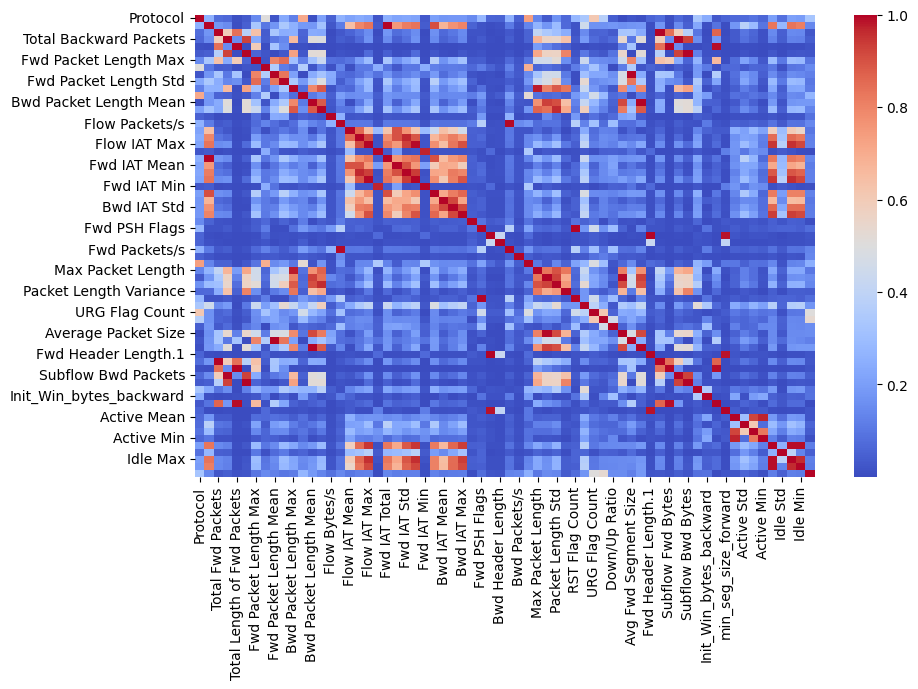

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.show()

<p>Aqui é criado a parte superior da matriz de correlação, excluindo a diagonal, para facilitar a identificação de variáveis altamente correlacionadas entre si.</p>

In [ ]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
upper.shape

(66, 66)

<p>Aqui será identificado e selecionado as colunas mais altamente correlacionadas (correlação maior que 0.9) e remover uma delas com base na variância (a que tiver menor variância).</p>

In [ ]:
to_drop = []

for column in upper.columns:
    high_corr = upper[column][upper[column] > 0.9].index.tolist()
    for correlated_column in high_corr:
        var_column = X_benign[column].var()
        var_correlated = X_benign[correlated_column].var()

        if var_column < var_correlated:
            to_drop.append(column)
        else:
            to_drop.append(correlated_column)


In [ ]:
to_drop = list(set(to_drop))

print(f'Colunas que serão removidas por correlação + baixa variância: {to_drop}')

Colunas que serão removidas por correlação + baixa variância: ['Idle Max', 'Fwd IAT Std', 'Subflow Bwd Packets', 'Idle Min', 'Active Min', 'act_data_pkt_fwd', 'Fwd IAT Max', 'Bwd IAT Mean', 'Avg Bwd Segment Size', 'Bwd Packet Length Mean', 'min_seg_size_forward', 'Fwd PSH Flags', 'Fwd Header Length', 'Packet Length Std', 'Packet Length Mean', 'Idle Mean', 'Bwd IAT Std', 'Bwd Packet Length Max', 'Total Fwd Packets', 'Fwd Packet Length Mean', 'Flow IAT Min', 'Total Length of Fwd Packets', 'Fwd IAT Total', 'Flow IAT Std', 'Bwd IAT Max', 'Bwd IAT Total', 'Fwd IAT Mean', 'Average Packet Size', 'Total Length of Bwd Packets', 'Total Backward Packets', 'Active Mean', 'Fwd Packets/s']


In [ ]:
X_reduced_corr = X_benign.drop(columns=to_drop)

In [ ]:
X_reduced_corr.shape

(19924, 47)

In [ ]:
X_reduced_corr

,Protocol,Flow Duration,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Std,Bwd Packet Length Min,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Max,Fwd IAT Min,Bwd IAT Min,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Bwd Header Length,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Avg Fwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,Active Std,Active Max,Idle Std,Inbound
0,6,1,0.0,0.0,0.000000,0.0,0.000000,0.000000,2.000000e+06,1.000000e+00,1.0,1.0,0.0,0,0,0,0,0.000000,0.0,0.0,0.000000,0,0,0,0,1,0,0,0,0.0,0.000000,56,0,0,0,0,0,0,2,0,0,8192,-1,0.000000e+00,0.0,0.000000e+00,1
1,6,266,46.0,0.0,18.780309,0.0,0.000000,578947.368421,1.879699e+04,6.650000e+01,263.0,1.0,0.0,0,0,0,0,0.000000,0.0,46.0,320.666667,0,0,1,0,0,1,0,0,0.0,30.800000,100,0,0,0,0,0,0,5,154,0,256,-1,0.000000e+00,0.0,0.000000e+00,0
2,6,20637,0.0,0.0,0.000000,0.0,16.979399,3004.312642,2.907399e+02,4.127400e+03,20632.0,0.0,1.0,0,0,0,100,242.283278,0.0,31.0,228.809524,0,0,0,0,0,1,1,0,5.0,0.000000,20,0,0,0,0,0,0,1,0,62,256,254,0.000000e+00,0.0,0.000000e+00,0
3,6,148,0.0,0.0,0.000000,0.0,0.000000,0.000000,2.027027e+04,7.400000e+01,147.0,0.0,1.0,0,0,0,40,13513.513514,0.0,0.0,0.000000,0,0,0,0,0,1,1,0,2.0,0.000000,20,0,0,0,0,0,0,1,0,0,254,0,0.000000e+00,0.0,0.000000e+00,1
4,0,113580323,0.0,0.0,0.000000,0.0,0.000000,0.000000,3.697824e-01,2.770252e+06,9958914.0,1.0,0.0,0,0,0,0,0.000000,0.0,0.0,0.000000,0,0,0,0,0,0,0,0,0.0,0.000000,0,0,0,0,0,0,0,42,0,0,-1,-1,1.199478e+06,4155120.0,1.172700e+06,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19919,6,550740,0.0,0.0,0.000000,31.0,0.000000,56.287904,5.447216e+00,2.753700e+05,550737.0,3.0,0.0,0,0,0,20,1.815739,0.0,31.0,240.250000,0,0,0,0,0,1,0,0,0.0,0.000000,40,0,0,0,0,0,0,2,0,31,30016,64095,0.000000e+00,0.0,0.000000e+00,1
19920,6,337766,31.0,31.0,0.000000,0.0,17.897858,275.338548,1.184252e+01,1.125887e+05,337762.0,0.0,1.0,0,0,0,60,8.881889,0.0,31.0,192.200000,0,0,1,0,0,1,1,0,3.0,31.000000,20,0,0,0,0,0,0,1,31,62,64095,30016,0.000000e+00,0.0,0.000000e+00,0
19921,6,228,0.0,0.0,0.000000,0.0,0.000000,0.000000,1.315789e+04,1.140000e+02,225.0,0.0,3.0,0,0,0,40,8771.929825,0.0,0.0,0.000000,0,0,0,0,0,1,1,0,2.0,0.000000,20,0,0,0,0,0,0,1,0,0,30016,0,0.000000e+00,0.0,0.000000e+00,1
19922,17,47709,43.0,43.0,0.000000,97.0,0.000000,5868.913622,8.384162e+01,1.590300e+04,47703.0,3.0,3.0,0,0,0,40,41.920812,43.0,97.0,874.800000,0,0,0,0,0,0,0,0,1.0,43.000000,40,0,0,0,0,0,0,2,86,194,-1,-1,0.000000e+00,0.0,0.000000e+00,0


<h2 style="color: rgb(100, 200, 34);">Normalização dos Dados</h2>

<p>Tratar os dados do dataset a fim de possuir apenas valores dentro de um intervalo específico.</p>

<p>Fazer o Hold-Out antes da normalização, a fim de evitar data leak</p>

In [ ]:
X_reduced_corr.shape

(19924, 47)

<p>Divide o dataset para teste (30%) e treino (70%)</p>

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_reduced_corr, y_benign, test_size=0.3, random_state=42, stratify=y_benign)

In [ ]:
top_features = X_train.columns 
top_features

Index(['Protocol', 'Flow Duration', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Std',
       'Bwd Packet Length Min', 'Bwd Packet Length Std', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Max', 'Fwd IAT Min',
       'Bwd IAT Min', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags',
       'Bwd Header Length', 'Bwd Packets/s', 'Min Packet Length',
       'Max Packet Length', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count',
       'URG Flag Count', 'CWE Flag Count', 'ECE Flag Count', 'Down/Up Ratio',
       'Avg Fwd Segment Size', 'Fwd Header Length.1', 'Fwd Avg Bytes/Bulk',
       'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk',
       'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate', 'Subflow Fwd Packets',
       'Subflow Fwd Bytes', 'Subflow Bwd Bytes', 'Init_Win_bytes_forward',
       'Init_Win_bytes_backward', 'Active Std', 'Active Max', 'Idle 

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled

array([[ 1.26464641, -0.32228087, -0.19147652, ..., -0.16959407,
        -0.09660706, -0.4639308 ],
       [-0.72047927, -0.32300919, -0.27583882, ..., -0.16959407,
        -0.09660706, -0.4639308 ],
       [ 1.26464641, -0.32228585, -0.20489779, ..., -0.16959407,
        -0.09660706, -0.4639308 ],
       ...,
       [ 1.26464641, -0.32228197, -0.19339384, ..., -0.16959407,
        -0.09660706, -0.4639308 ],
       [-0.72047927, -0.32300287, -0.27775615, ..., -0.16959407,
        -0.09660706,  2.15549388],
       [ 1.26464641, -0.32227523, -0.18764187, ..., -0.16959407,
        -0.09660706, -0.4639308 ]], shape=(13946, 47))

In [ ]:
X_val_scaled = scaler.transform(X_val)

In [ ]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)

In [ ]:
X_train_scaled_df.shape

(13946, 47)

In [ ]:
X_train_scaled_df.columns

Index(['Protocol', 'Flow Duration', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Std',
       'Bwd Packet Length Min', 'Bwd Packet Length Std', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Max', 'Fwd IAT Min',
       'Bwd IAT Min', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags',
       'Bwd Header Length', 'Bwd Packets/s', 'Min Packet Length',
       'Max Packet Length', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count',
       'URG Flag Count', 'CWE Flag Count', 'ECE Flag Count', 'Down/Up Ratio',
       'Avg Fwd Segment Size', 'Fwd Header Length.1', 'Fwd Avg Bytes/Bulk',
       'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk',
       'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate', 'Subflow Fwd Packets',
       'Subflow Fwd Bytes', 'Subflow Bwd Bytes', 'Init_Win_bytes_forward',
       'Init_Win_bytes_backward', 'Active Std', 'Active Max', 'Idle 

In [ ]:
X_test_final_udp = X_test_final_udp[top_features]

In [ ]:
X_test_final_scaled_udp = scaler.transform(X_test_final_udp)

In [ ]:
X_test_final_scaled_df_udp = pd.DataFrame(X_test_final_scaled_udp, columns=top_features, index=X_test_final_syn.index)

In [ ]:
X_test_final_syn = X_test_final_syn[top_features]
X_test_final_syn.shape

(44737, 47)

In [ ]:
X_test_final_scaled_syn = scaler.transform(X_test_final_syn)

In [ ]:
X_test_final_scaled_df_syn = pd.DataFrame(X_test_final_scaled_syn, columns=top_features, index=X_test_final_syn.index)

In [ ]:
X_test_final_scaled_df_syn.shape

(44737, 47)

In [ ]:
X_test_final_scaled_df_syn.head()

,Protocol,Flow Duration,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Std,Bwd Packet Length Min,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Max,Fwd IAT Min,Bwd IAT Min,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Bwd Header Length,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Avg Fwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,Active Std,Active Max,Idle Std,Inbound
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
21,-0.720479,3.616024,-0.189559,-0.25677,-0.165849,-0.510993,-0.230783,-0.076697,-0.334879,5.990281,4.368468,-0.057656,-0.170562,0.0,0.0,0.0,0.04643,-0.069263,-0.360055,-0.227839,-0.098603,0.0,-0.062924,2.61015,0.0,-0.467693,1.182315,-0.516732,0.0,-0.970614,-0.143793,0.047405,0.0,0.0,0.0,0.0,0.0,0.0,0.071169,-0.013649,-0.046148,-0.445015,-0.314931,-0.131358,-0.075847,1.823755,-0.463931
24,-0.720479,3.616578,-0.189559,-0.25677,-0.165849,-0.510993,-0.230783,-0.076697,-0.334879,5.991166,4.368472,-0.057652,-0.170562,0.0,0.0,0.0,0.04643,-0.069263,-0.360055,-0.227839,-0.098603,0.0,-0.062924,2.61015,0.0,-0.467693,1.182315,-0.516732,0.0,-0.970614,-0.143793,0.047405,0.0,0.0,0.0,0.0,0.0,0.0,0.071169,-0.013649,-0.046148,-0.445015,-0.315196,-0.131326,-0.075947,1.818312,-0.463931
26,-0.720479,3.616584,-0.189559,-0.25677,-0.165849,-0.510993,-0.230783,-0.076697,-0.334879,5.991175,4.368472,-0.057652,-0.357947,0.0,0.0,0.0,0.04643,-0.069263,-0.360055,-0.227839,-0.098603,0.0,-0.062924,2.61015,0.0,-0.467693,1.182315,-0.516732,0.0,-0.970614,-0.143793,0.047405,0.0,0.0,0.0,0.0,0.0,0.0,0.071169,-0.013649,-0.046148,-0.444959,-0.314931,-0.131322,-0.075986,1.818313,-0.463931
30,-0.720479,3.616038,-0.189559,-0.25677,-0.165849,-0.510993,-0.230783,-0.076697,-0.334879,5.990304,4.368464,-0.057652,-0.170562,0.0,0.0,0.0,0.04643,-0.069263,-0.360055,-0.227839,-0.098603,0.0,-0.062924,2.61015,0.0,-0.467693,1.182315,-0.516732,0.0,-0.970614,-0.143793,0.047405,0.0,0.0,0.0,0.0,0.0,0.0,0.071169,-0.013649,-0.046148,-0.445182,-0.312455,-0.131334,-0.075888,1.823705,-0.463931
32,-0.720479,3.616043,-0.189559,-0.25677,-0.165849,-0.510993,-0.230783,-0.076697,-0.334879,5.990312,4.368465,-0.057652,-0.357947,0.0,0.0,0.0,0.04643,-0.069263,-0.360055,-0.227839,-0.098603,0.0,-0.062924,2.61015,0.0,-0.467693,1.182315,-0.516732,0.0,-0.970614,-0.143793,0.047405,0.0,0.0,0.0,0.0,0.0,0.0,0.071169,-0.013649,-0.046148,-0.445126,-0.315284,-0.131286,-0.075917,1.823708,-0.463931


In [ ]:
y_test_final_udp = y_test_final_udp.apply(lambda x: 0 if x == 'BENIGN' else 1)

In [ ]:
y_test_final_syn = y_test_final_syn.apply(lambda x: 0 if x == 'BENIGN' else 1)

In [ ]:
y_test_final_syn.value_counts()

Label
0    35790
1     8947
Name: count, dtype: int64

<h2 style="color: rgb(100, 200, 34);">Treinamento do Isolation Forest</h2>

<p>Aqui será feito o treinamento do modelo.</p>

In [ ]:
X_train_scaled_df.shape

(13946, 47)

In [ ]:
model = IsolationForest(max_samples=0.9,n_estimators=172,contamination=0.064, random_state=42)
model.fit(X_train_scaled_df)

,n_estimators,107
,max_samples,0.9
,contamination,0.011
,max_features,1.0
,bootstrap,False
,n_jobs,None
,random_state,42
,verbose,0
,warm_start,False


In [ ]:
model.n_features_in_

47

<h2 style="color: rgb(100, 200, 34);">Predições</h2>

In [ ]:
y_pred_val = model.predict(X_val_scaled_df)

In [ ]:
y_pred_val = np.where(y_pred_val == -1, 1, 0)

In [ ]:
y_pred_val

array([0, 0, 0, ..., 0, 0, 0], shape=(5978,))

In [ ]:
X_attacks = df_malign.drop('Label', axis=1)

In [ ]:
X_attacks.replace([np.inf, -np.inf], np.nan, inplace=True)

In [ ]:
X_attacks.fillna(X_attacks.mean(), inplace=True)

In [ ]:
X_attacks.head()

,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Inbound
19924,17,48,2,0,2944.0,0.0,1472.0,1472.0,1472.0,0.0,0.0,0.0,0.0,0.0,6.133333e+07,4.166667e+04,48.0,0.0,48.0,48.0,48.0,48.0,0.0,48.0,48.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,4.166667e+04,0.0,1472.0,1472.0,1472.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,2208.0,1472.0,0.0,0,0,0,0,0,0,0,2,2944,0,0,-1,-1,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
19925,17,2,2,0,2944.0,0.0,1472.0,1472.0,1472.0,0.0,0.0,0.0,0.0,0.0,1.472000e+09,1.000000e+06,2.0,0.0,2.0,2.0,2.0,2.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,-2,0,1.000000e+06,0.0,1472.0,1472.0,1472.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,2208.0,1472.0,0.0,-2,0,0,0,0,0,0,2,2944,0,0,-1,-1,1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
19926,17,1,2,0,2944.0,0.0,1472.0,1472.0,1472.0,0.0,0.0,0.0,0.0,0.0,2.944000e+09,2.000000e+06,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,-2,0,2.000000e+06,0.0,1472.0,1472.0,1472.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,2208.0,1472.0,0.0,-2,0,0,0,0,0,0,2,2944,0,0,-1,-1,1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
19927,17,1,2,0,2944.0,0.0,1472.0,1472.0,1472.0,0.0,0.0,0.0,0.0,0.0,2.944000e+09,2.000000e+06,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,2960,0,2.000000e+06,0.0,1472.0,1472.0,1472.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,2208.0,1472.0,0.0,2960,0,0,0,0,0,0,2,2944,0,0,-1,-1,1,1480,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
19928,17,1,2,0,2896.0,0.0,1448.0,1448.0,1448.0,0.0,0.0,0.0,0.0,0.0,2.896000e+09,2.000000e+06,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,2.000000e+06,0.0,1448.0,1448.0,1448.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,2172.0,1448.0,0.0,0,0,0,0,0,0,0,2,2896,0,0,-1,-1,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [ ]:
X_attacks_selected = X_attacks[top_features]
X_attacks_scaled = scaler.transform(X_attacks_selected)

In [ ]:
X_val_scaled.shape

(5978, 47)

In [ ]:
X_val_total = np.vstack((X_val_scaled, X_attacks_scaled))
y_val_total = np.concatenate((np.zeros(len(X_val_scaled)), np.ones(len(X_attacks_scaled))))

<h2 style="color: rgb(100, 200, 34);">Métricas</h2>

In [ ]:
y_val.isna().sum()

np.int64(0)

In [ ]:
y_pred_val

array([0, 0, 0, ..., 0, 0, 0], shape=(5978,))

In [ ]:
y_pred_val = model.predict(X_val_total)

c:\data_science_iforest_ddos\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [ ]:
y_pred_val = np.where(y_pred_val == 1, 0, 1) 

In [ ]:
y_pred_val

array([0, 0, 0, ..., 0, 1, 1], shape=(10957,))

In [ ]:
predict_syn = classification_report(y_val_total, y_pred_val, digits=4)
print(predict_syn)

              precision    recall  f1-score   support

         0.0     0.9871    0.9883    0.9877      5978
         1.0     0.9859    0.9845    0.9852      4979

    accuracy                         0.9866     10957
   macro avg     0.9865    0.9864    0.9865     10957
weighted avg     0.9866    0.9866    0.9866     10957



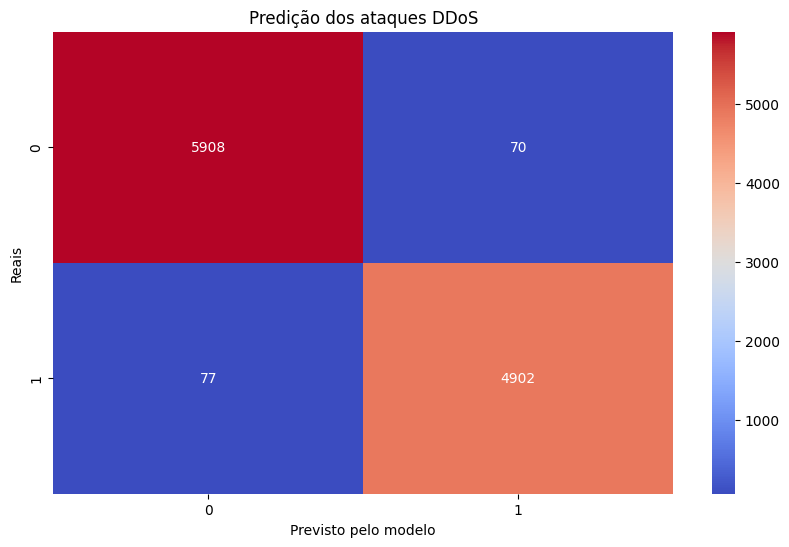

In [ ]:
cm = confusion_matrix(y_val_total, y_pred_val)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm')
plt.title('Predição dos ataques DDoS')
plt.xlabel('Previsto pelo modelo')
plt.ylabel('Reais')
plt.show()

<h2 style="color: rgb(100, 200, 34);">Validação Final Externa</h2>

<p>Aqui será usado um dataset externo do CIC-DDoS2019 para validar e provar a generalização do projeto.</p>

In [ ]:
y_pred_test_syn = model.predict(X_test_final_scaled_df_syn)

In [ ]:
y_pred_test_udp = model.predict(X_test_final_scaled_df_udp)

In [ ]:
y_pred_test_syn

array([1, 1, 1, ..., 1, 1, 1], shape=(44737,))

In [ ]:
y_pred_test_udp = np.where(y_pred_test_udp == -1, 1, 0)

In [ ]:
y_pred_test_syn = np.where(y_pred_test_syn == -1, 1, 0)


In [ ]:
y_pred_test_syn

array([0, 0, 0, ..., 0, 0, 0], shape=(44737,))

In [ ]:
y_val.isna().sum()

np.int64(0)

In [ ]:
predict_udp = classification_report(y_test_final_udp, y_pred_test_udp, digits=4)
print(predict_udp)

In [ ]:
predict_syn = classification_report(y_test_final_syn, y_pred_test_syn, digits=4)
print(predict_syn)

              precision    recall  f1-score   support

           0     0.7976    0.9813    0.8800     35790
           1     0.0511    0.0040    0.0075      8947

    accuracy                         0.7859     44737
   macro avg     0.4243    0.4927    0.4437     44737
weighted avg     0.6483    0.7859    0.7055     44737



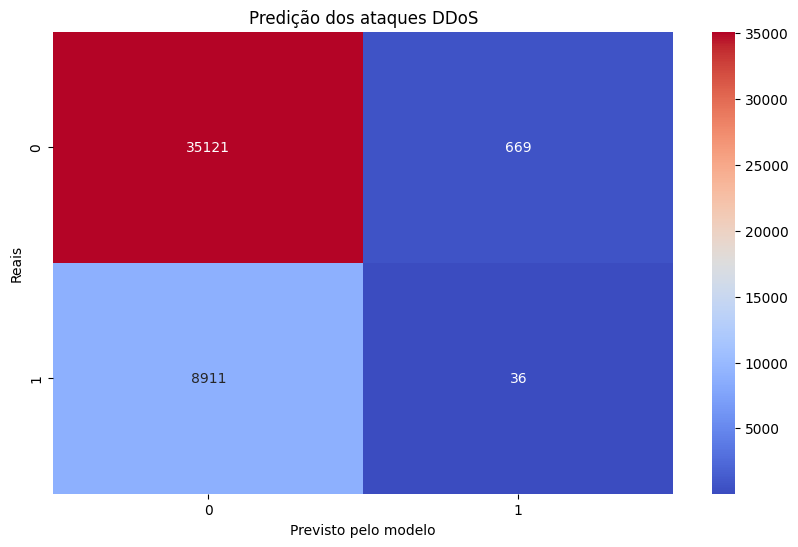

In [ ]:
cm = confusion_matrix(y_test_final_syn, y_pred_test_syn)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm')
plt.title('Predição dos ataques DDoS SYN')
plt.xlabel('Previsto pelo modelo')
plt.ylabel('Reais')
plt.show()

In [ ]:
cm = confusion_matrix(y_test_final_udp, y_pred_test_udp)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm')
plt.title('Predição dos ataques DDoS UDP')
plt.xlabel('Previsto pelo modelo')
plt.ylabel('Reais')
plt.show()

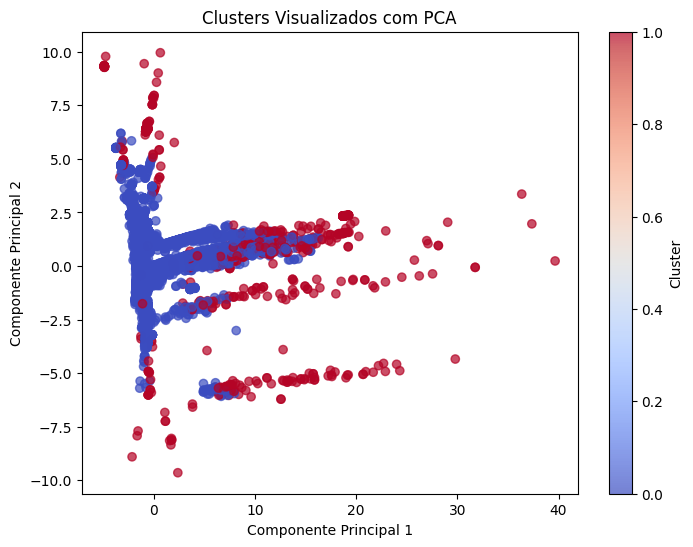

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_test_final_scaled_df_syn)

plt.figure(figsize=(8,6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_pred_test_syn,cmap='coolwarm', alpha=0.7)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Clusters Visualizados com PCA SYN')
plt.colorbar(label='Cluster')
plt.show()


In [ ]:
X_reduced = pca.fit_transform(X_test_final_scaled_df_udp)

plt.figure(figsize=(8,6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_pred_test_udp,cmap='coolwarm', alpha=0.7)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Clusters Visualizados com PCA UDP')
plt.colorbar(label='Cluster')
plt.show()

<p>Ao final pode-se perceber que o modelo se aprendeu corretamento os dados ao manter sua acurácia ao decorrer do projeto inteiro.</p>